In [2]:
import sys
sys.path.append('..')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy.stats import t, pearsonr
import xgboost as xg
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from scipy.stats import norm
from sklearn.impute import KNNImputer
###Outliers
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from xgboost import XGBClassifier
import joblib
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Load the dataset

In [1]:
wave1 = pd.read_csv('data_wave1.csv').set_index('pident')

# Convert all columns to numeric, forcing invalid parsing to NaN
wave1 = wave1.apply(pd.to_numeric, errors='coerce')

# Replace negative values (-1, -2, etc.) with NaN
wave1 = wave1.where(wave1 >= 0, np.nan)
wave1.columns.to_list()

In [2]:
columns = ['ahsCRP', 'aIL6', 'aTNFa', 'aGp',
          'aApoA1', 'aApoB', 'aRemnant_C', 'aVLDL_C', 'aHDL_C',
          'aHDL2_C', 'aHDL3_C', 'aVLDL_D', 'aHDL_D', 'aDAG', 
          'aSerum_TG', 'aVLDL_TG', 'aLDL_TG', 'aHDL_TG', 'aMUFA',
          'aTotFA', 'aFALen', 'aAce', 'aTyr', 'aIle', 'acidep05']

# Select only the specified columns from wave1
selected_combined_data = wave1[columns]

# Drop rows where 'acidep05' has missing values (NaN)
cleaned_data = selected_combined_data.dropna(subset=['acidep05'])

# Calculate the sum of missing values for each column
missing_values_sum = cleaned_data.isna().sum()

# Rename 'acidep05' to 'MDD' in selected_wave1
cleaned_data.rename(columns={'acidep05': 'MDD'}, inplace=True)

# Renaming dictionary with units included
rename_dict = {
    'ahsCRP': 'hs-CRP (mg/L)',
    'aIL6': 'IL-6 (pg/mL)',
    'aTNFa': 'TNF-α (pg/mL)',
    'aGp': 'Glycoprotein acetyls (mmol/L)',
    'aApoA1': 'Apolipoprotein A1 (g/L)',
    'aApoB': 'Apolipoprotein B (g/L)',
    'aRemnant_C': 'Remnant cholesterol (mmol/L)',
    'aVLDL_C': 'VLDL cholesterol (mmol/L)',
    'aHDL_C': 'HDL cholesterol (mmol/L)',
    'aHDL2_C': 'HDL-2 cholesterol (mmol/L)',
    'aHDL3_C': 'HDL-3 cholesterol (mmol/L)',
    'aVLDL_D': 'VLDL diameter (nm)',
    'aHDL_D': 'HDL diameter (nm)',
    'aDAG': 'Diacylglycerol (mmol/L)',
    'aSerum_TG': 'Serum triglycerides (mmol/L)',
    'aVLDL_TG': 'VLDL triglycerides (mmol/L)',
    'aLDL_TG': 'LDL triglycerides (mmol/L)',
    'aHDL_TG': 'HDL triglycerides (mmol/L)',
    'aMUFA': 'Monounsaturated FAs (mmol/L)',
    'aTotFA': 'Total FAs (mmol/L)',
    'aFALen': 'FA chain length (estimated)',
    'aAce': 'Acetate (mmol/L)',
    'aTyr': 'Tyrosine (mmol/L)',
    'aIle': 'Isoleucine (mmol/L)'
}

# Rename columns in the dataframe
cleaned_data.rename(columns=rename_dict, inplace=True)

# Display the renamed columns
print(cleaned_data.columns)

In [3]:
# Initialize the KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Impute the missing values in the entire DataFrame
cleaned_data = pd.DataFrame(imputer.fit_transform(cleaned_data), columns=cleaned_data.columns)

In [6]:
MDD_counts = cleaned_data['MDD'].value_counts() 
MDD_counts

MDD
0.0    1866
1.0    1115
Name: count, dtype: int64

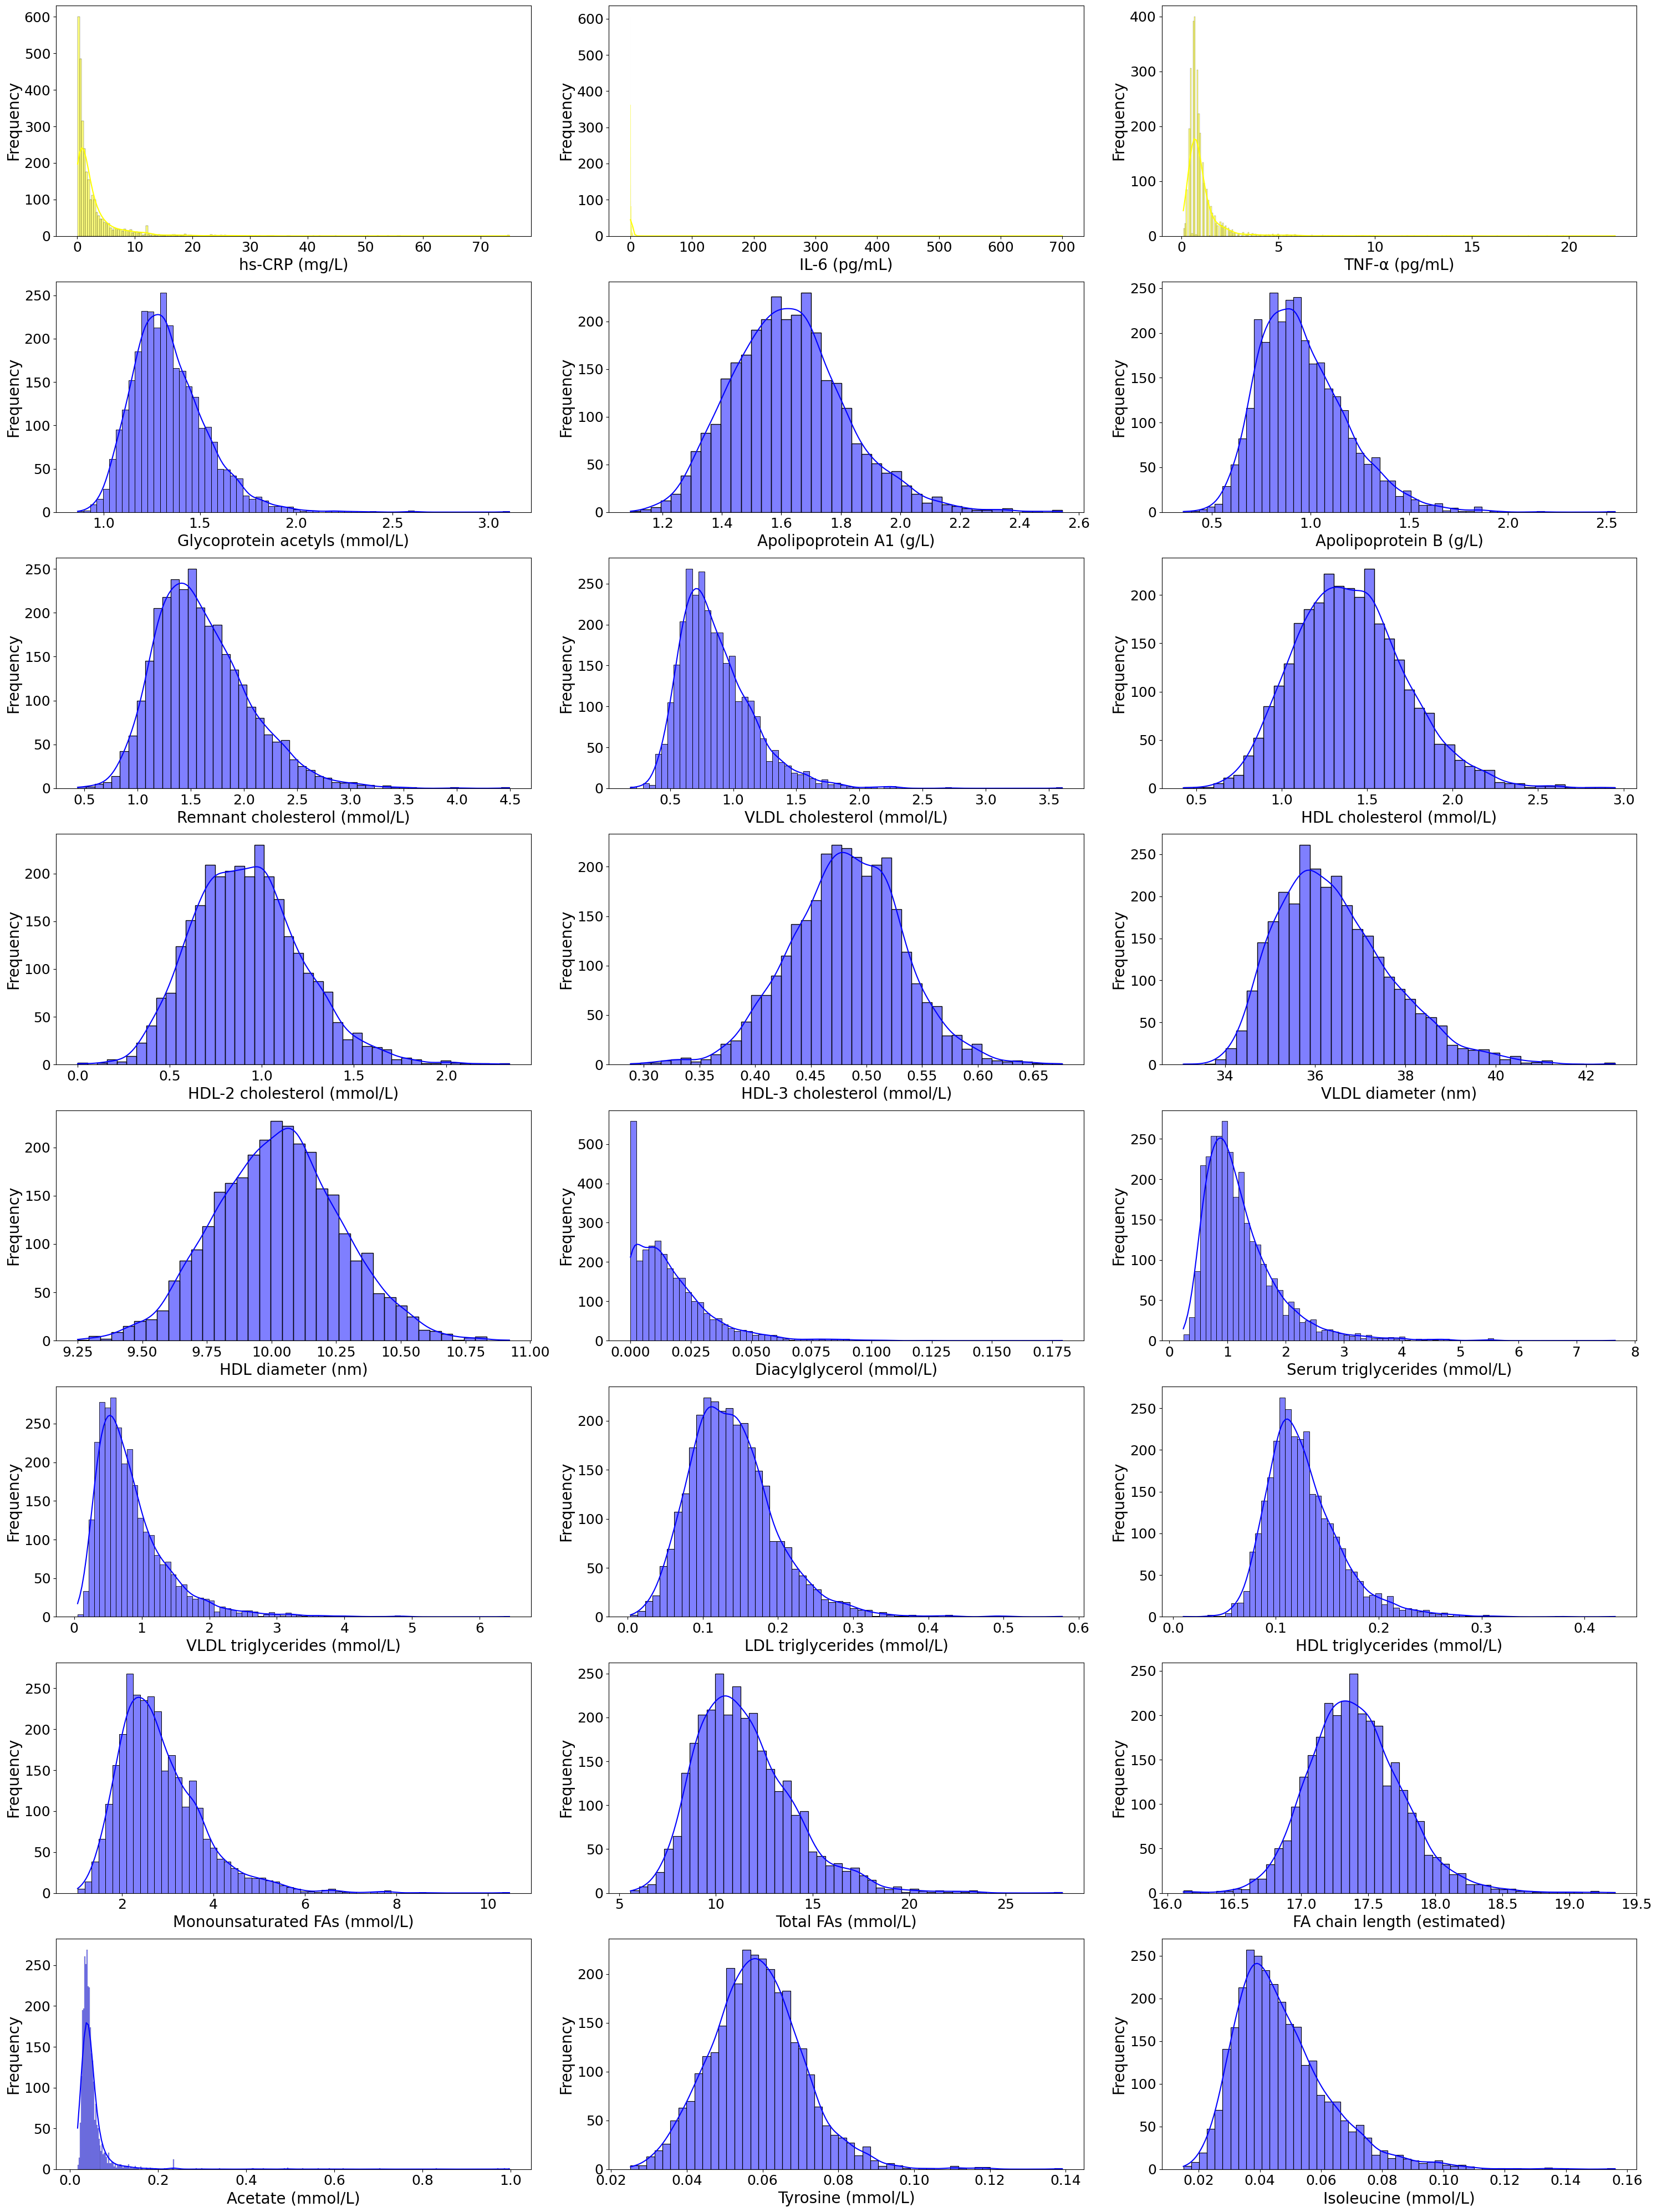

In [10]:
# List of metabolites
metabolites = ['hs-CRP (mg/L)', 'IL-6 (pg/mL)', 'TNF-α (pg/mL)',
       'Glycoprotein acetyls (mmol/L)', 'Apolipoprotein A1 (g/L)',
       'Apolipoprotein B (g/L)', 'Remnant cholesterol (mmol/L)',
       'VLDL cholesterol (mmol/L)', 'HDL cholesterol (mmol/L)',
       'HDL-2 cholesterol (mmol/L)', 'HDL-3 cholesterol (mmol/L)',
       'VLDL diameter (nm)', 'HDL diameter (nm)', 'Diacylglycerol (mmol/L)',
       'Serum triglycerides (mmol/L)', 'VLDL triglycerides (mmol/L)',
       'LDL triglycerides (mmol/L)', 'HDL triglycerides (mmol/L)',
       'Monounsaturated FAs (mmol/L)', 'Total FAs (mmol/L)',
       'FA chain length (estimated)', 'Acetate (mmol/L)', 'Tyrosine (mmol/L)',
       'Isoleucine (mmol/L)']

# Filter the dataframe to include only the metabolites
metabolites_data = cleaned_data[metabolites]

# Create a grid of subplots
fig, axes = plt.subplots(8, 3, figsize=(30, 40))  # Increase the figure size and adjust grid size
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Metabolites to color differently
yellow_metabolites = ['hs-CRP (mg/L)', 'IL-6 (pg/mL)', 'TNF-α (pg/mL)']

# Plot each metabolite's distribution
for i, col in enumerate(metabolites):
    color = 'yellow' if col in yellow_metabolites else 'blue'  # Choose yellow for specific metabolites
    sns.histplot(metabolites_data[col], kde=True, ax=axes[i], color=color)  # Plot histogram with selected color
    #axes[i].set_title(col, fontsize=20)  # Larger font size for titles
    axes[i].tick_params(axis='both', which='major', labelsize=18)  # Increase tick label size
    axes[i].set_ylabel('Frequency', fontsize=20)  # Larger y-axis label font size
    axes[i].set_xlabel(col, fontsize=20)  # Remove x-axis label for cleaner appearance

# Hide any unused subplots
for j in range(len(metabolites), len(axes)):
    fig.delaxes(axes[j])  # Delete unused subplots

plt.tight_layout()  # Adjust layout to prevent overlap

plt.savefig("large_distribution_plots_colored_high_res.png", dpi=600)  # Save as a high-res image
plt.show()


/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have v

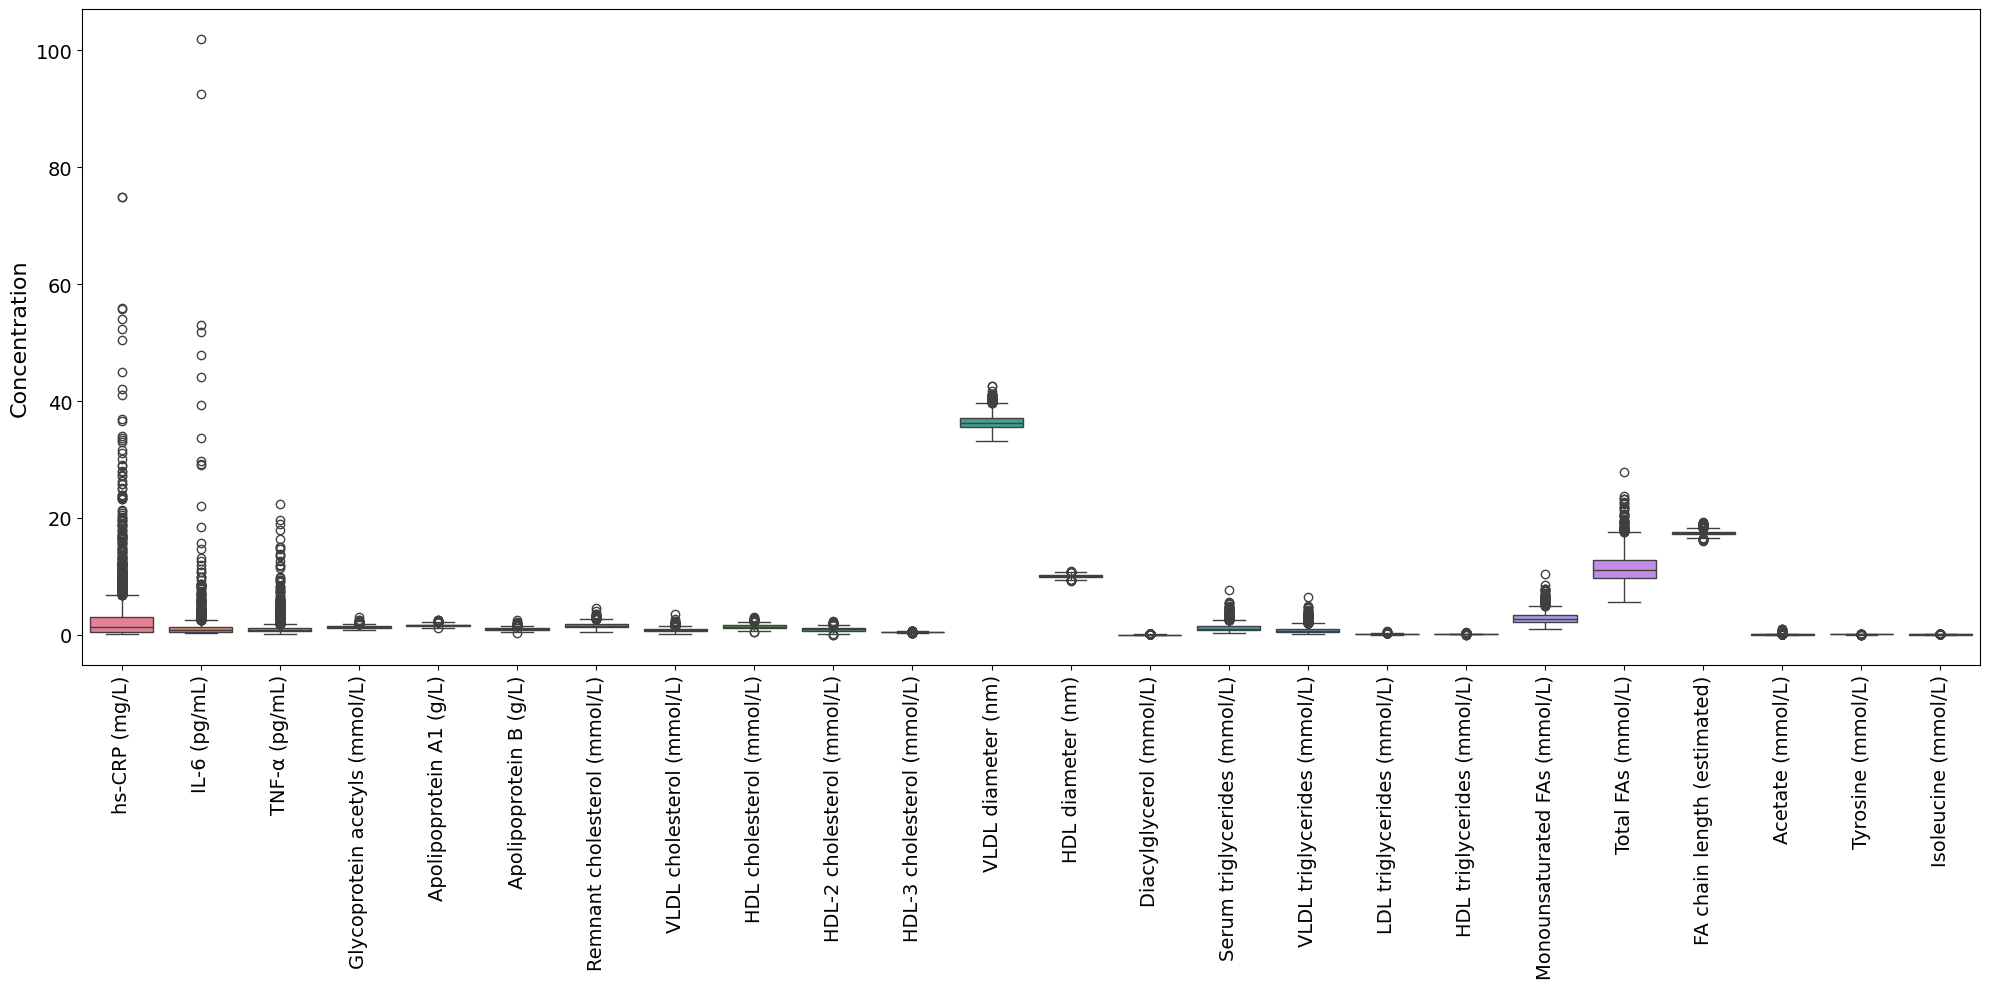

In [18]:
from sklearn.ensemble import IsolationForest

# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
metabolites_data_df = cleaned_data[metabolites_data]  # Subset metabolites from the cleaned data
metabolites_data_df['outlier'] = iso_forest.fit_predict(metabolites_data_df)

plt.figure(figsize=(20, 10))  # Adjust width and height as needed

# Create the boxplot, dropping the 'outlier' column if it exists
sns.boxplot(data=metabolites_data_df.drop(columns=['outlier'], errors='ignore'))

# Rotate x-axis labels for better readability and increase font size
plt.xticks(rotation=90, fontsize=14)  # Adjust fontsize as needed
plt.yticks(fontsize=14)  # Increase y-axis font size

# Add y-axis title
plt.ylabel('Concentration', fontsize=16)  # Customize title and fontsize as needed

plt.tight_layout()
# Save the plot as a high-resolution PNG image
output_path = "boxplot_outliers.png"  # Specify the file name
plt.savefig(output_path, dpi=600)  # Save with 600 DPI resolution
plt.show()

In [8]:
# Identify and drop outliers
cleaned_data_no_outliers = metabolites_data_df[metabolites_data_df['outlier'] != -1].copy()
cleaned_data_no_outliers = cleaned_data_no_outliers.drop(columns=['outlier'])

# Add the binary MDD column to the cleaned dataset
mdd_column = cleaned_data.loc[cleaned_data_no_outliers.index, 'MDD']
cleaned_data_no_outliers['MDD'] = mdd_column

# Ensure metabolites_data columns exist in final_df
final_df = cleaned_data_no_outliers.copy()
missing_columns = [col for col in metabolites_data if col not in final_df.columns]
if missing_columns:
    raise ValueError(f"The following columns are missing in final_df: {missing_columns}")

# Subset the data
X = final_df[metabolites_data]  # Features
y_depression = final_df['MDD']  # Target variable

Feature columns: Index(['hs-CRP', 'IL-6', 'TNF-a', 'AGP', 'ApoA1', 'ApoB', 'Remnant Chol',
       'VLDL Chol', 'HDL Chol', 'HDL-2 Chol', 'HDL-3 Chol', 'VLDL Diameter',
       'HDL Diameter', 'Diacylglycerol', 'Serum Trig', 'VLDL Trig', 'LDL Trig',
       'HDL Trig', 'Monounsaturated FAs', 'Total FAs', 'FAs chain length',
       'Acetate', 'Tyrosine', 'Isoleucine'],
      dtype='object')


Hyperparameters

In [4]:
import optuna

X_train, X_test, y_train, y_test = train_test_split(X, y_depression, test_size=0.2, random_state=42)

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'missing': np.nan,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**param)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_f1 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_weighted')

    return cv_f1.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print(f'Best hyperparameters: {best_params}')

Model

/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a fut

/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a fut

/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a fut

Cross-validated Accuracy: 0.76
Cross-validated F1 Score: 0.76


/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/angelakoloi/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a fut

Validation Accuracy: 0.78
Validation F1 Score: 0.78
Sensitivity (Recall): 0.79
Specificity: 0.76

Confusion Matrix:
[[138  43]
 [ 36 138]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.76      0.78       181
         1.0       0.76      0.79      0.78       174

    accuracy                           0.78       355
   macro avg       0.78      0.78      0.78       355
weighted avg       0.78      0.78      0.78       355



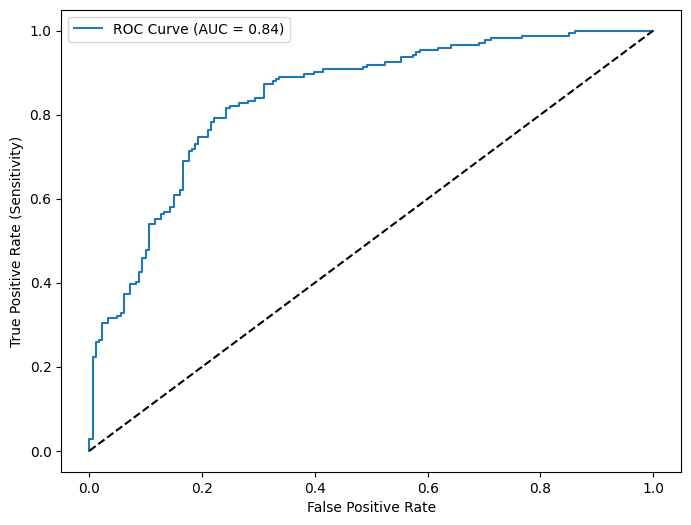

In [31]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.utils import resample
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

class XGBoostClassifierPipeline:
    np.random.seed(123)

    def __init__(self, X, y, best_params):
        self.X = X
        self.y = y
        self.best_params = best_params
        self.model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.y_pred = None
        self.y_pred_proba = None

    def preprocess_data(self):
        # Handle imbalanced classes with SMOTE
        smote = SMOTE(random_state=42)
        X_smote, y_smote = smote.fit_resample(self.X, self.y)

        # Split the data into training and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_smote, y_smote, test_size=0.1, random_state=42
        )

    def train_model(self):
        # Use the best parameters from Optuna
        self.model = XGBClassifier(
            **self.best_params,  # Pass the optimized hyperparameters
            missing=np.nan,
            use_label_encoder=False,
            eval_metric='logloss'
        )

        # Perform 5-fold cross-validation on the original (non-permuted) data
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_accuracy = cross_val_score(self.model, self.X_train, self.y_train, cv=kfold, scoring='accuracy')
        cv_f1 = cross_val_score(self.model, self.X_train, self.y_train, cv=kfold, scoring='f1_weighted')

        print(f'Cross-validated Accuracy: {cv_accuracy.mean():.2f}')
        print(f'Cross-validated F1 Score: {cv_f1.mean():.2f}')

        # Fit the model on the entire training data
        self.model.fit(self.X_train, self.y_train)

        # Evaluate on the validation set
        self.y_pred = self.model.predict(self.X_test)
        self.y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]

        # Accuracy and F1 score
        accuracy = accuracy_score(self.y_test, self.y_pred)
        f1 = f1_score(self.y_test, self.y_pred, average='weighted')
        print(f'Validation Accuracy: {accuracy:.2f}')
        print(f'Validation F1 Score: {f1:.2f}')

        # Sensitivity (Recall for the positive class)
        sensitivity = recall_score(self.y_test, self.y_pred)
        print(f'Sensitivity (Recall): {sensitivity:.2f}')

        # Confusion Matrix and Specificity Calculation
        cm = confusion_matrix(self.y_test, self.y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        print(f'Specificity: {specificity:.2f}')

        print("\nConfusion Matrix:")
        print(cm)
        print("\nClassification Report:")
        print(classification_report(self.y_test, self.y_pred, digits=2))  # Limit decimals in classification report

        # Plotting the ROC Curve
        fpr, tpr, thresholds = roc_curve(self.y_test, self.y_pred_proba)
        auc_score = roc_auc_score(self.y_test, self.y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc='best')
        plt.savefig("roc_curve_high_res.png", dpi=600)  # Save the ROC curve as a PNG file with 600 DPI
        plt.show()

    def bootstrap_feature_importance(self, n_bootstraps=2):
        """
        Perform bootstrap sampling to calculate feature importance with mean and standard deviation.
        """
        feature_importance_list = []

        # Bootstrap iterations
        for i in range(n_bootstraps):
            X_resampled, y_resampled = resample(self.X_train, self.y_train, random_state=i)
            self.model.fit(X_resampled, y_resampled)
            importance = self.model.feature_importances_
            feature_importance_list.append(importance)

        # Calculate mean and standard deviation of feature importance
        mean_importance = np.mean(feature_importance_list, axis=0)
        std_importance = np.std(feature_importance_list, axis=0)

        # Retrieve feature names
        feature_names = self.model.get_booster().feature_names

        # Store results in DataFrame
        self.importance_results = pd.DataFrame({
            'Feature': feature_names,
            'Mean Importance': mean_importance,
            'Std Importance': std_importance
        }).sort_values(by='Mean Importance', ascending=False)

        print("\nBootstrapped Feature Importance:")
        print(self.importance_results)

    def permutation_test(self, n_permutations=2):
        """
        Perform permutation test to calculate p-values for feature importance.
        """
        X_train_np = self.X_train.to_numpy()
        original_importance = self.model.feature_importances_
        permuted_importances = np.zeros((n_permutations, len(original_importance)))

        # Permutation iterations
        for i in range(n_permutations):
            for j in range(X_train_np.shape[1]):
                X_permuted = X_train_np.copy()
                np.random.shuffle(X_permuted[:, j])
                self.model.fit(X_permuted, self.y_train)
                permuted_importances[i, j] = self.model.feature_importances_[j]

        # Calculate p-values
        p_values = np.mean(permuted_importances >= original_importance, axis=0)
        feature_names = self.X_train.columns

        # Store results in DataFrame
        self.p_values_df = pd.DataFrame({
            'Feature': feature_names,
            'Original Importance': original_importance,
            'P-Value': p_values
        }).sort_values(by='Original Importance', ascending=False)

        print("\nP-Values for Feature Importances:")
        print(self.p_values_df)

        return self.p_values_df

    def generate_feature_importance_table(self):
        """
        Combine bootstrap and permutation test results into a single table.
        """
        if self.importance_results.empty:
            print("No importance results to combine. Run bootstrap_feature_importance() first.")
            return

        if not hasattr(self, 'p_values_df') or self.p_values_df.empty:
            print("No p-values available. Run permutation_test() first.")
            return

        # Merge importance results with p-values
        combined_results = self.importance_results.merge(
            self.p_values_df[['Feature', 'P-Value']], on='Feature', how='inner'
        )

        # Sort results by Mean Importance
        combined_results = combined_results.sort_values(by='Mean Importance', ascending=False)

        print("\nCombined Feature Importance Table:")
        print(combined_results)

        # Optionally save to a CSV file
        combined_results.to_csv("feature_importance_with_p_values.csv", index=False)

        return combined_results
    
    def plot_feature_importance(self):
        """
        Plot bar chart with error bars for all features based on bootstrap results.
        """
        # Check if importance results exist
        if self.importance_results.empty:
            print("No importance results to plot. Run bootstrap_feature_importance() first.")
            return

        # Prepare data for plotting
        features = self.importance_results['Feature']
        mean_importance = self.importance_results['Mean Importance']
        std_importance = self.importance_results['Std Importance']

        # Create the bar plot
        plt.figure(figsize=(12, 8))
        plt.barh(features, mean_importance, xerr=std_importance, align='center',
                 color='skyblue', ecolor='black', capsize=5)
        plt.xlabel('Mean Importance', fontsize=12)
        plt.ylabel('Features', fontsize=12)
      #  plt.title('Feature Importance with Error Bars (Bootstrap Results)', fontsize=16)
        plt.gca().invert_yaxis()  # Invert y-axis for better readability
        plt.tight_layout()

        # Save the plot as a high-resolution PNG
        plt.savefig("feature_importance_plot.png", dpi=600)
        plt.show()
pipeline = XGBoostClassifierPipeline(X, y_depression, best_params)
pipeline.preprocess_data()
pipeline.train_model()


Bootstrapped Feature Importance:
                Feature  Mean Importance  Std Importance
12         HDL Diameter         0.064080        0.004182
16             LDL Trig         0.057613        0.004033
19            Total FAs         0.054216        0.005801
4                 ApoA1         0.051238        0.004470
3                   AGP         0.051202        0.003909
10           HDL-3 Chol         0.048892        0.003596
17             HDL Trig         0.041412        0.003556
15            VLDL Trig         0.041326        0.005222
23           Isoleucine         0.040595        0.003471
13       Diacylglycerol         0.039645        0.003624
18  Monounsaturated FAs         0.039547        0.003869
11        VLDL Diameter         0.039050        0.004034
8              HDL Chol         0.038588        0.004655
9            HDL-2 Chol         0.037521        0.004157
2                 TNF-a         0.037420        0.003531
5                  ApoB         0.037007        0.0041

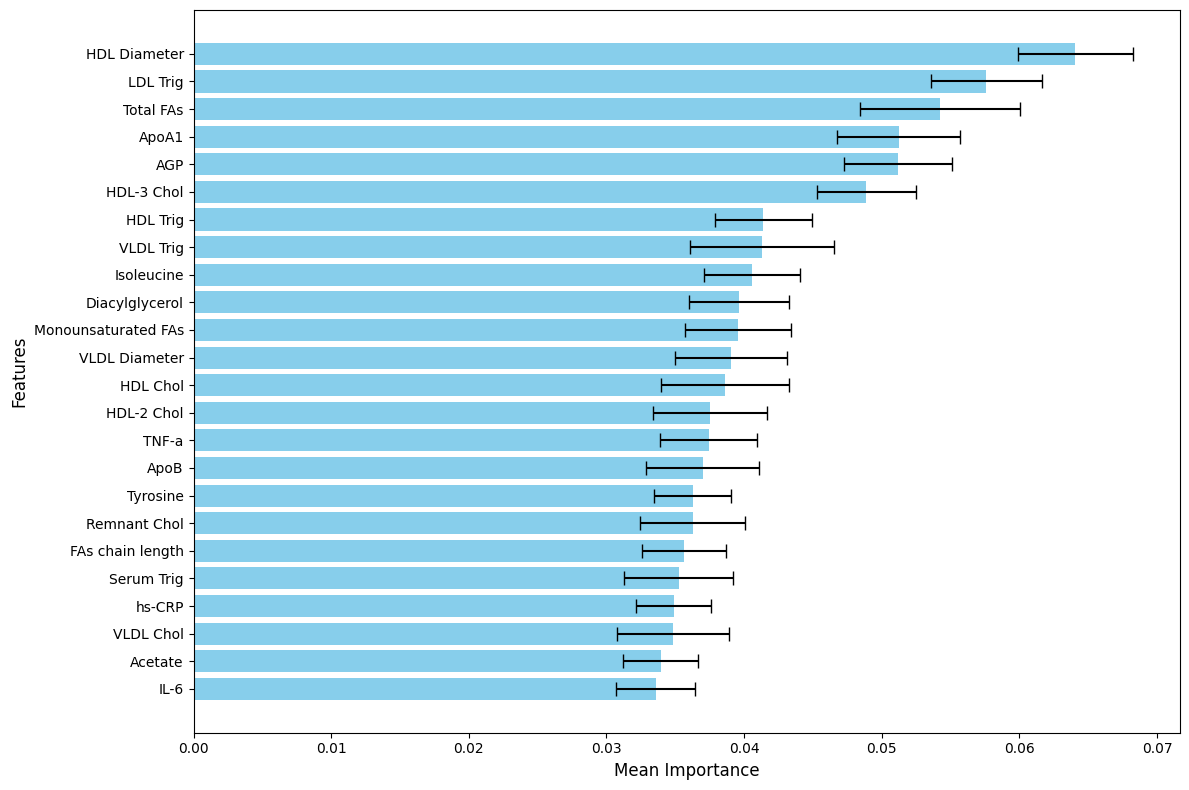

In [32]:
np.random.seed(123)
pipeline.bootstrap_feature_importance(n_bootstraps=1000)
#pipeline.permutation_test(n_permutations=100)
pipeline.plot_feature_importance()

